# Sparse subframes

Here we modify objective function to add an L1 penalty to the gains, thereby achieving a sparse gain vector.

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

import frame_whitening as fw
from frame_whitening.types import *
import frame_whitening.simulation as fwsim
import frame_whitening.plot as fwplt

## Create two ellipses

Frame dims: (2, 4)  (more than necessary)


[(-4.0, 4.0), (-4.0, 4.0)]

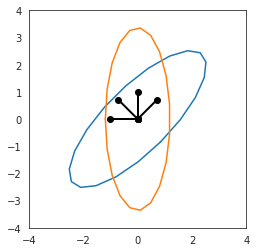

In [85]:
np.random.seed(420)

Q0 = fw.rot2(np.deg2rad(45))
kappa = 8
Cxx0 = Q0 @ np.diag([kappa, 1]) @ Q0.T * 1 / (np.sqrt(kappa))


Q1 = fw.rot2(np.deg2rad(45)) @ Q0
Cxx1 = Q1 @ np.diag([kappa, 1]) @ Q1.T * 1 / (np.sqrt(kappa))

covariance_list = [Cxx0, Cxx1]
cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0, Cxx1]]
# N, K = 2, 6
# W = np.random.randn(N, K)

W = np.concatenate([Q0, Q1], axis=1)
W = fw.normalize_frame(W)
N, K = W.shape
print("Frame dims:", W.shape, " (more than necessary)")

fig, ax = plt.subplots(1, 1)
fwplt.plot_ellipse(Cxx0, color="C0", ax=ax)
fwplt.plot_ellipse(Cxx1, color="C1", ax=ax)
fwplt.plot_frame2d(W, ax=ax)
ax.axis('square')
ax.set(xlim=(-4, 4), ylim=(-4, 4))

## Run Simulation

In [82]:
batch_size = 1024
n_batch = 5000
lr_g = 1e-3
beta = 10.

func_type, alpha = FuncType.G_EXPONENTIAL, None  # alpha must be None if not POWER
# func_type, alpha = FuncType.POWER, 1  # alpha must be None if not POWER
get_y, get_dg = fwsim.get_opt_funcs(func_type) 

if func_type == FuncType.POWER:
    get_y = partial(get_y, alpha=alpha)
    get_dg = partial(get_dg, alpha=alpha, beta=beta)
else:
    get_y = partial(get_y)
    get_dg = partial(get_dg, beta=beta)

g0 = fwsim.init_g_const(0.1, K, func_type, alpha=alpha)

g_last, g_all, errors = fwsim.simulate(
    cholesky_list,
    W,
    get_y,
    get_dg,
    batch_size,
    n_batch,
    lr_g,
    g0=g0,
)

## Plot

### Error convergence

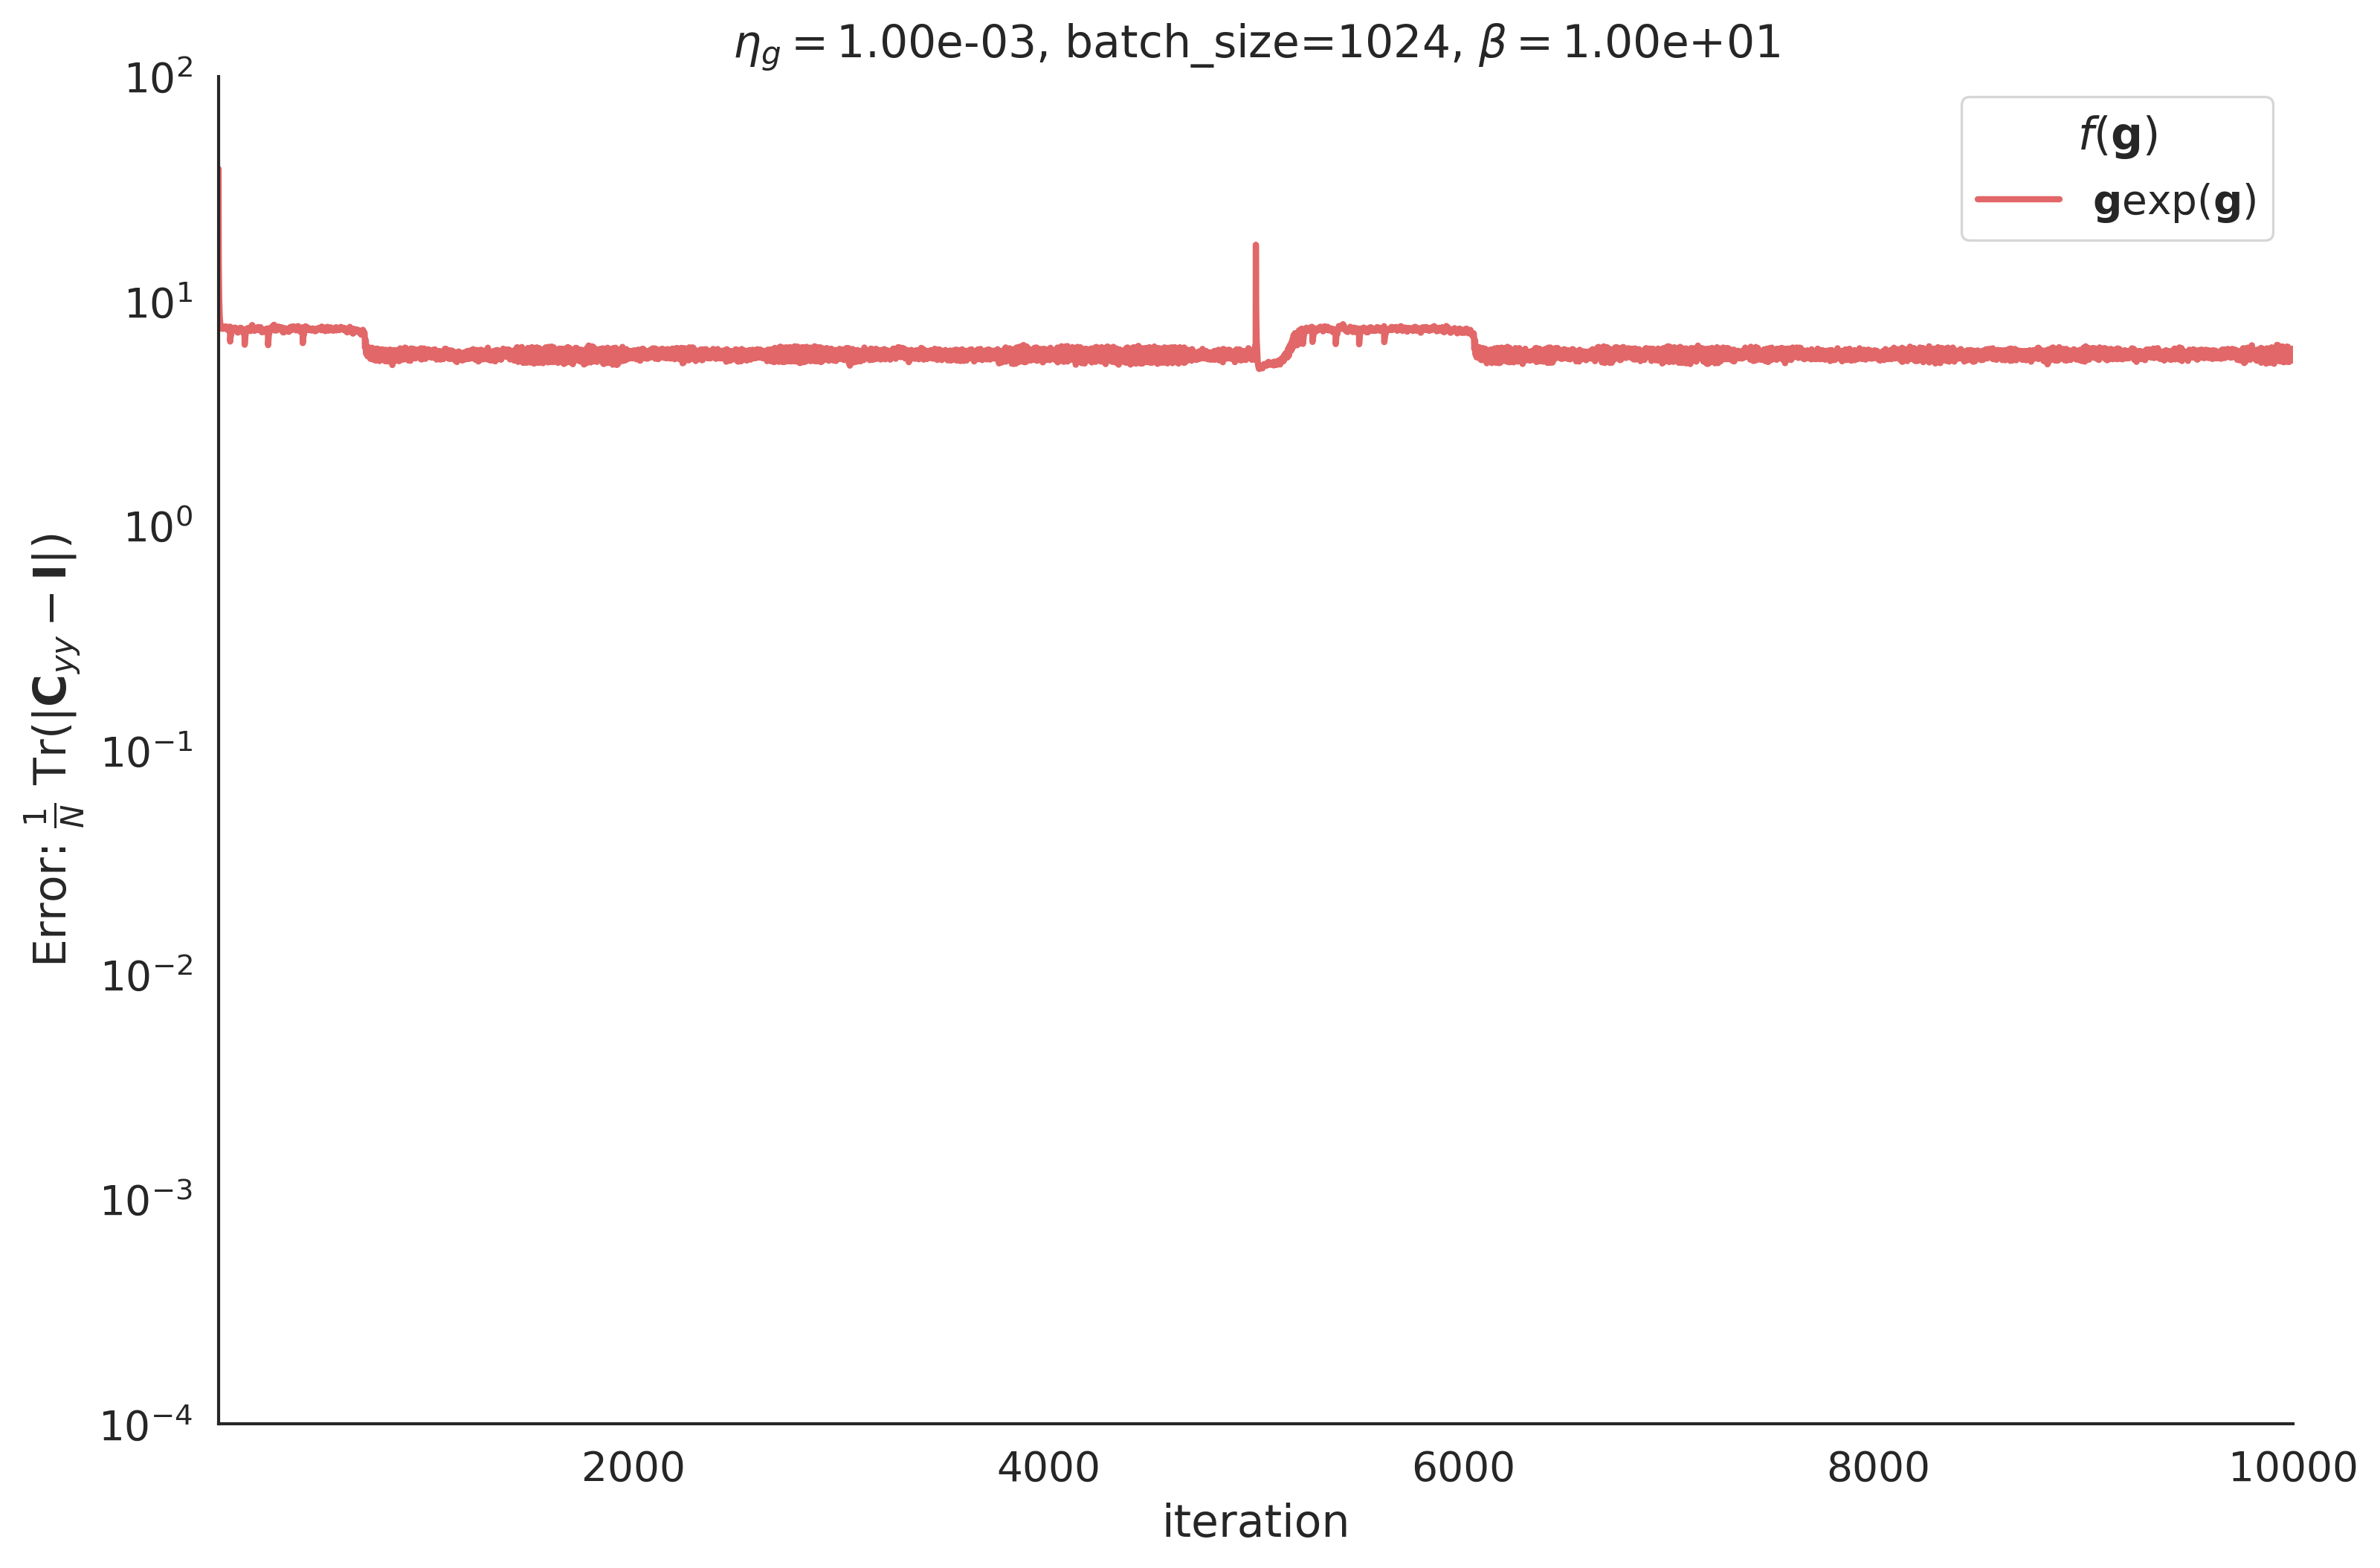

In [83]:
if func_type == FuncType.G_EXPONENTIAL:
    func_label = r"${\bf g}\exp({\bf g})$"
elif func_type == FuncType.EXPONENTIAL:
    func_label = r"$\exp({\bf g})$"
elif func_type == FuncType.POWER:
    func_label = r"${\bf g}"+("^{:d}$".format(alpha + 1))

with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
    N, K = W.shape

    label = r"${\bf g}\exp({\bf g})$"
    ax.plot(errors, color="C3", label=label, linewidth=2, alpha=0.7)

    ax.set(
        yscale="log",
        # xscale="log",
        ylim=(1e-4, 1e2),
        xlim=(1, n_batch * len(cholesky_list)),
        xlabel="iteration",
        ylabel=r"Error: $\frac{1}{N}$ Tr($\vert {\bf C}_{yy} - {\bf I} \vert$)",
        title=f"$\eta_g=${lr_g:.2e}, batch_size={batch_size}, $\\beta=${beta:.2e}",
    )
    ax.legend(title=r"$f({\bf g})$")
    sns.despine()

### Gains over time

Only 3 of the 6 possible frame vectors are needed to whiten, so the rest are set to zero.

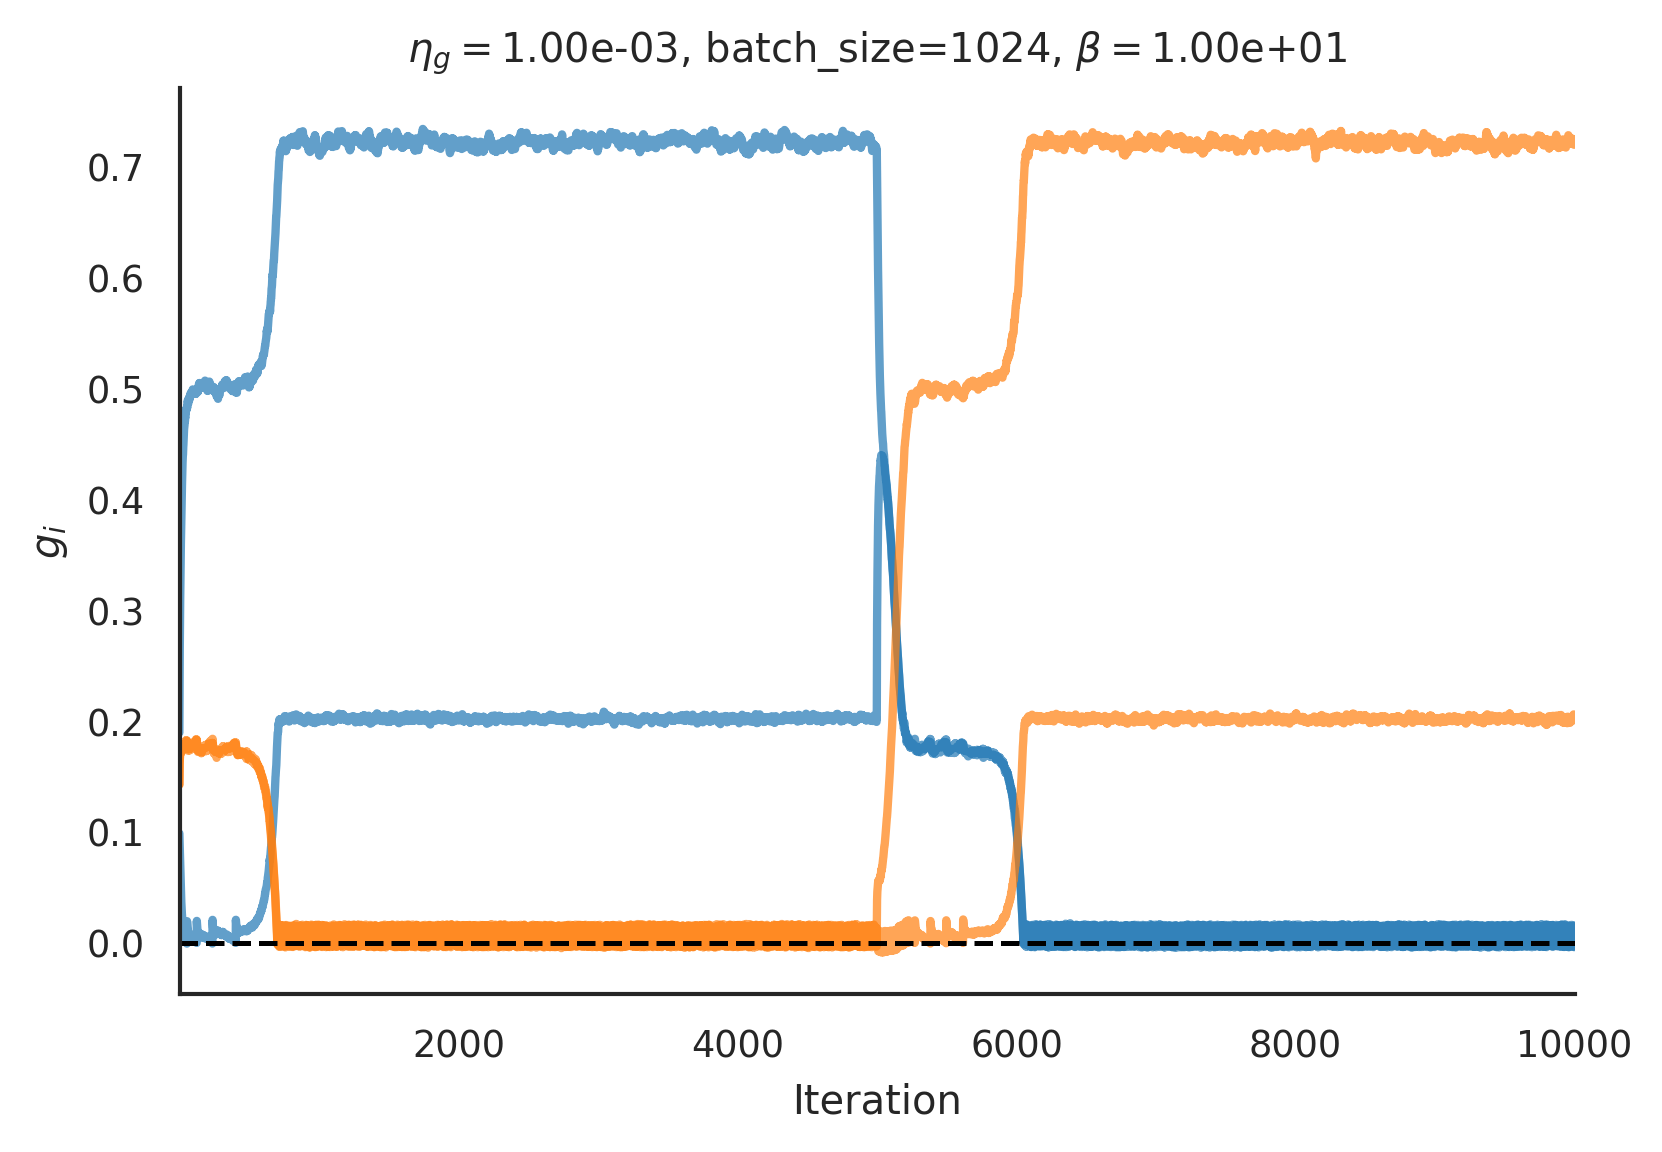

In [84]:
def f(g, func_type, alpha=None):
    if func_type == FuncType.G_EXPONENTIAL:
        return g*np.exp(g)
    elif func_type == FuncType.POWER:
        return np.power(g, alpha+1)
    else:  # FuncType.EXPONENTIAL
        return np.exp(g)

with sns.plotting_context("paper", font_scale=1):
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    N, K = W.shape

    label = r"${\bf g}^2$"
    gains_plot = f(g_all, func_type, alpha).T
    for g_plot, col in zip(gains_plot, ['C0', 'C0', 'C1', 'C1']):
        ax.plot(g_plot, color=col,  label=label, linewidth=2, alpha=0.7)
    ax.hlines(0, 0, n_batch*len(cholesky_list), linestyle="--", color="k")

    ax.set(
        # xscale="log",
        xlim=(1, n_batch*len(cholesky_list)),
        xlabel="Iteration",
        ylabel=r"$g_i$",
        title=f"$\eta_g=${lr_g:.2e}, batch_size={batch_size}, $\\beta=${beta:.2e}",
    )
    sns.despine()

### Plot the covariance before and after

C init
 [[1.59099026 1.23743687]
 [1.23743687 1.59099026]]
C whitened
 [[ 6.9465074  -1.46729101]
 [-1.46729101  6.71460711]]
C init
 [[3.53553391e-01 5.49532361e-16]
 [5.49532361e-16 2.82842712e+00]]
C whitened
 [[ 8.42723681 -0.0138294 ]
 [-0.0138294   5.41188291]]


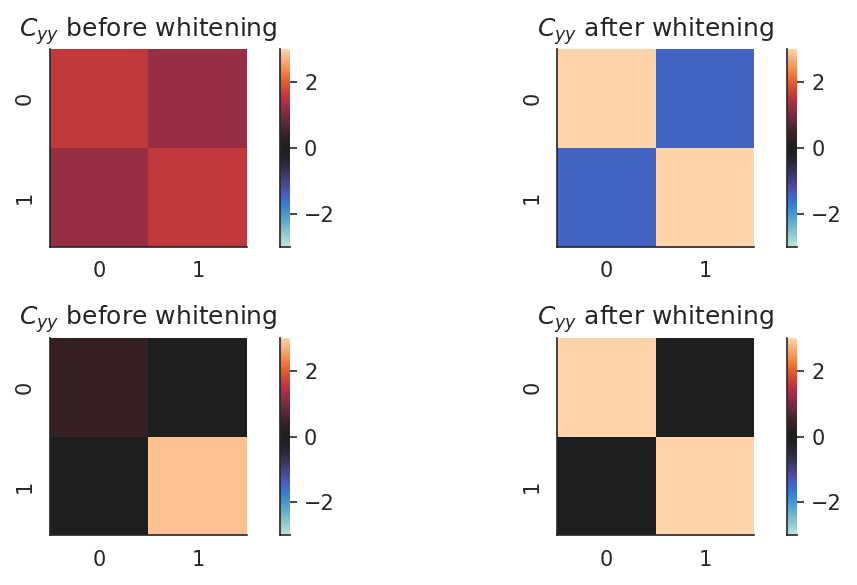

In [97]:
def heatmap(C, ax):
    """Helper for plotting covariances."""
    sns.heatmap(C, ax=ax, cmap="icefire", vmin=-3, vmax=3, cbar=True, square=True)


fig, ax = plt.subplots(2,2, figsize=(8,4), dpi=150)
for i, C in enumerate(covariance_list):
    idx = (i+1) * n_batch-100
    M = np.linalg.inv(W @ np.diag(f(g_all[idx], func_type, alpha)) @ W.T)
    print("C init\n", C)
    print("C whitened\n", M @ C @ M.T)

    heatmap(C, ax=ax[i,0])
    heatmap(M@C@M.T, ax=ax[i,1])
    ax[i, 0].set(title=r"$C_{yy}$ before whitening")
    ax[i, 1].set(title=r"$C_{yy}$ after whitening");
    fig.tight_layout()
    sns.despine()

array([0.01537838, 0.01211604, 0.45674192, 0.17199377])